### Loading liberary and dataset


In [1]:
library(deepnet)
library(faraway)
library(ggplot2)
library(mlbench)
library(neuralnet)
library(nnet)


In [2]:
data("BreastCancer")
# Clean off rows with missing data
BreastCancer <- BreastCancer[which(complete.cases(BreastCancer) == TRUE), ]
head(BreastCancer)
names(BreastCancer)


,Id,Cl.thickness,Cell.size,Cell.shape,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses,Class
,<chr>,<ord>,<ord>,<ord>,<ord>,<ord>,<fct>,<fct>,<fct>,<fct>,<fct>
1,1000025,5,1,1,1,2,1,3,1,1,benign
2,1002945,5,4,4,5,7,10,3,2,1,benign
3,1015425,3,1,1,1,2,2,3,1,1,benign
4,1016277,6,8,8,1,3,4,3,7,1,benign
5,1017023,4,1,1,3,2,1,3,1,1,benign
6,1017122,8,10,10,8,7,10,9,7,1,malignant


[1] "Id"              "Cl.thickness"    "Cell.size"       "Cell.shape"     
 [5] "Marg.adhesion"   "Epith.c.size"    "Bare.nuclei"     "Bl.cromatin"    
 [9] "Normal.nucleoli" "Mitoses"         "Class"

#### First, we create the dependent variable, and also the feature set of independent variables.


In [3]:
y <- as.matrix(BreastCancer[, 11])
y[which(y == "benign")] <- 0
y[which(y == "malignant")] <- 1
y <- as.numeric(y)
x <- as.numeric(as.matrix(BreastCancer[, 2:10]))
x <- matrix(as.numeric(x), ncol = 9)


### Method 1: The deepnet package


#### We then use the function nn.train from the deepnet package to model the neural network. As can be seen in the program code below, we have 5 nodes in the single hidden layer.


In [4]:
nn <- nn.train(x, y, hidden = c(5))
yy <- nn.predict(nn, x)
print(head(yy))


          [,1]
[1,] 0.2526945
[2,] 0.4254596
[3,] 0.2775864
[4,] 0.4260973
[5,] 0.2681852
[6,] 0.4651980


#### We take the output of the network and convert it into classes, such that class ???0??? is benign and class ???1??? is malignant. We then construct the ???confusion matrix??? to see how well the model does in-sample. The table function here creates the confusion matrix, which is a tabulation of how many observations that were benign and malignant were correctly classified. This is a handy way of assessing how successful a machine learning model is at classification.


In [5]:
yhat <- matrix(0, length(yy), 1)
yhat[which(yy > mean(yy))] <- 1
yhat[which(yy <= mean(yy))] <- 0
cm <- table(y, yhat)
print(cm)
print(sum(diag(cm)) / sum(cm))


   yhat
y     0   1
  0 421  23
  1   4 235
[1] 0.9604685


### Method 2


#### For comparison, we try the neuralnet package. The commands are mostly the same. The function in the package is also called neuralnet.


In [6]:
df <- data.frame(cbind(x, y))
# We can adjust the number of hidden layer and compare.
nn <- neuralnet(y ~ V1 + V2 + V3 + V4 + V5 + V6 + V7 + V8 + V9, data = df, hidden = 5)

yy <- nn$net.result[[1]]
yhat <- matrix(0, length(y), 1)
yhat[which(yy > mean(yy))] <- 1
yhat[which(yy <= mean(yy))] <- 0
cm <- table(y, yhat)
print(cm)

print(sum(diag(cm)) / sum(cm))


   yhat
y     0   1
  0 432  12
  1   0 239
[1] 0.9824305


#### This package has an interesting function that allows plotting the neural network. Use the function plot() and pass the output object to it, in this case nn. This needs to be run interactively, but here is a sample outpt of the plot.


In [18]:
plot(nn)


### Method 3: nnet


In [8]:
data(ozone, package = "faraway")
head(ozone)


,O3,vh,wind,humidity,temp,ibh,dpg,ibt,vis,doy
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3,5710,4,28,40,2693,-25,87,250,33
2,5,5700,3,37,45,590,-24,128,100,34
3,5,5760,3,51,54,1450,25,139,60,35
4,6,5720,4,69,35,1568,15,121,60,36
5,4,5790,6,19,45,2631,-33,123,100,37
6,4,5790,3,25,55,554,-28,182,250,38


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


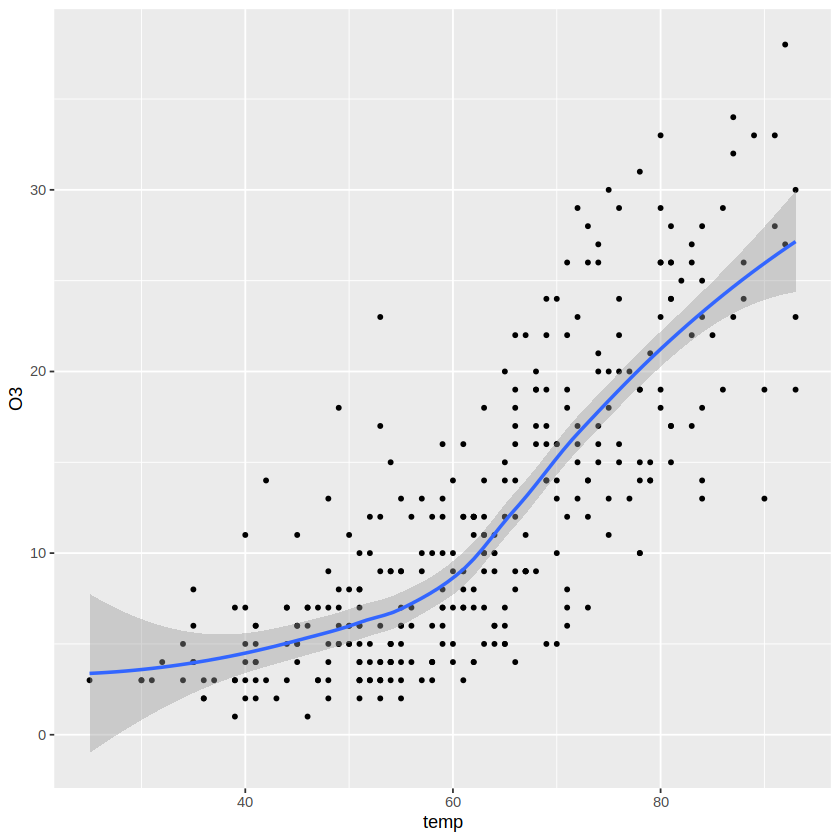

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


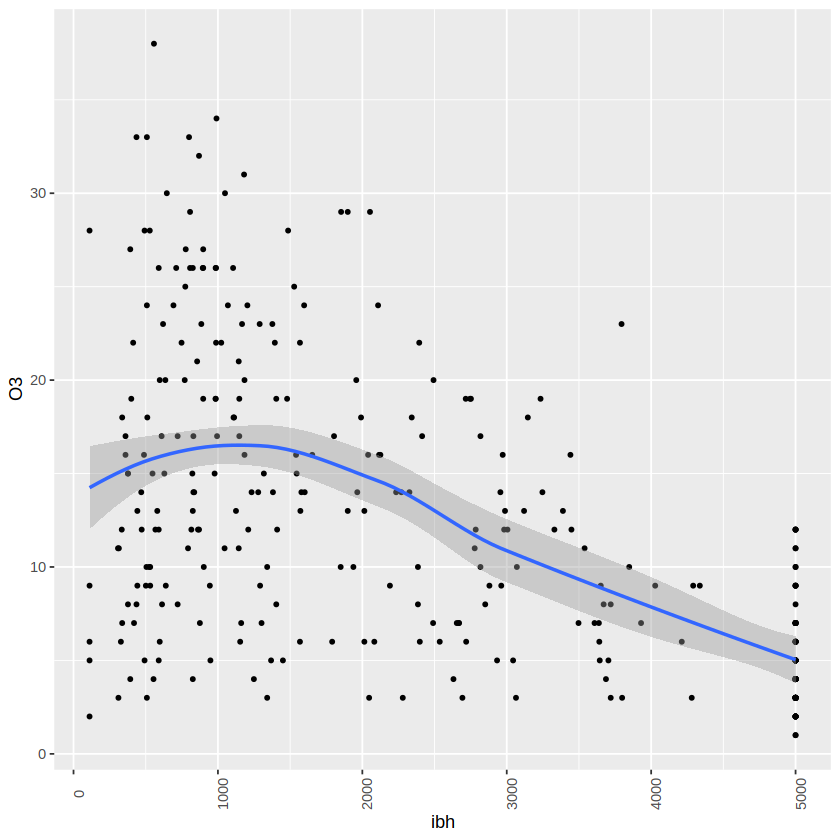

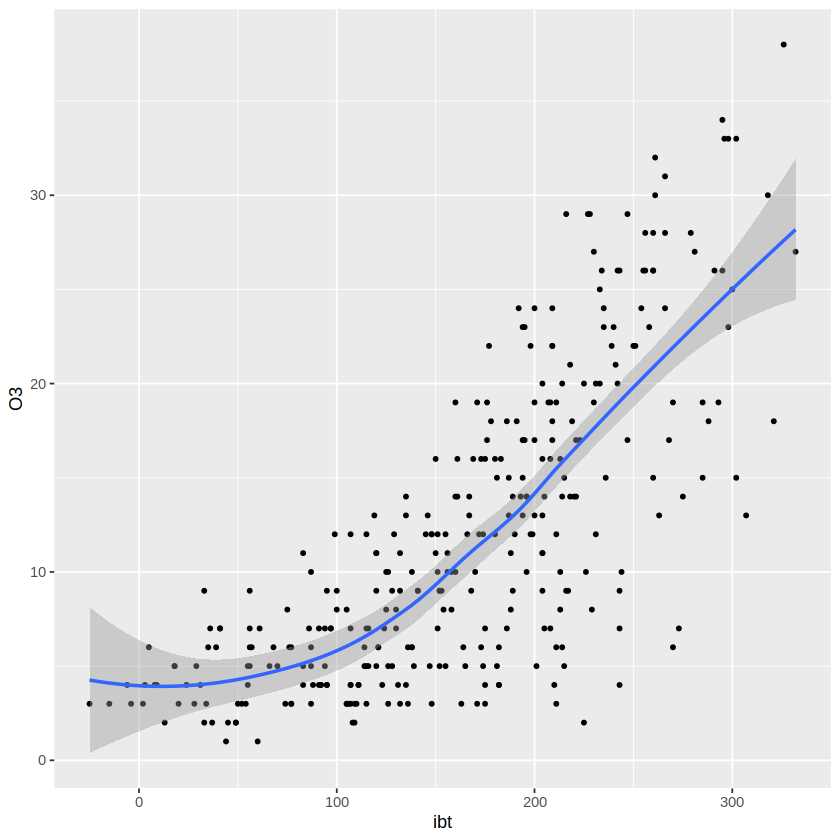

In [9]:
ggplot(ozone, aes(x = temp, y = O3)) +
    geom_point(size = 1) +
    geom_smooth()

ggplot(ozone, aes(x = ibh, y = O3)) +
    geom_point(size = 1) +
    geom_smooth() +
    theme(axis.text.x = element_text(angle = 90))

ggplot(ozone, aes(x = ibt, y = O3)) +
    geom_point(size = 1) +
    geom_smooth()


In [10]:
set.seed(123)
nnmdl <- nnet(O3 ~ temp + ibh + ibt, ozone, size = 2, linout = T)


# weights:  11
initial  value 61722.135446 
final  value 21115.406061 
converged


In [11]:
nnmdl$value


[1] 21115.41

#### Compare to the naive RSS (numerator of the sd)


In [12]:
sum((ozone$O3 - mean(ozone$O3))^2)


[1] 21115.41

#### Rescaled data First, rescale the data to see some improvement. Then use 100 random starting points for the weights (100 epochs) and find the best fit among these.


In [13]:
rescaled.ozone <- scale(ozone)

set.seed(25373)
best.rss <- NULL
for (i in 1:100) {
    nnmdl <- nnet(O3 ~ temp + ibh + ibt,
        data = rescaled.ozone, size = 2, linout = T, trace = F
    )
    best.rss[i] <- nnmdl$value
}

min(best.rss)


[1] 91.81211

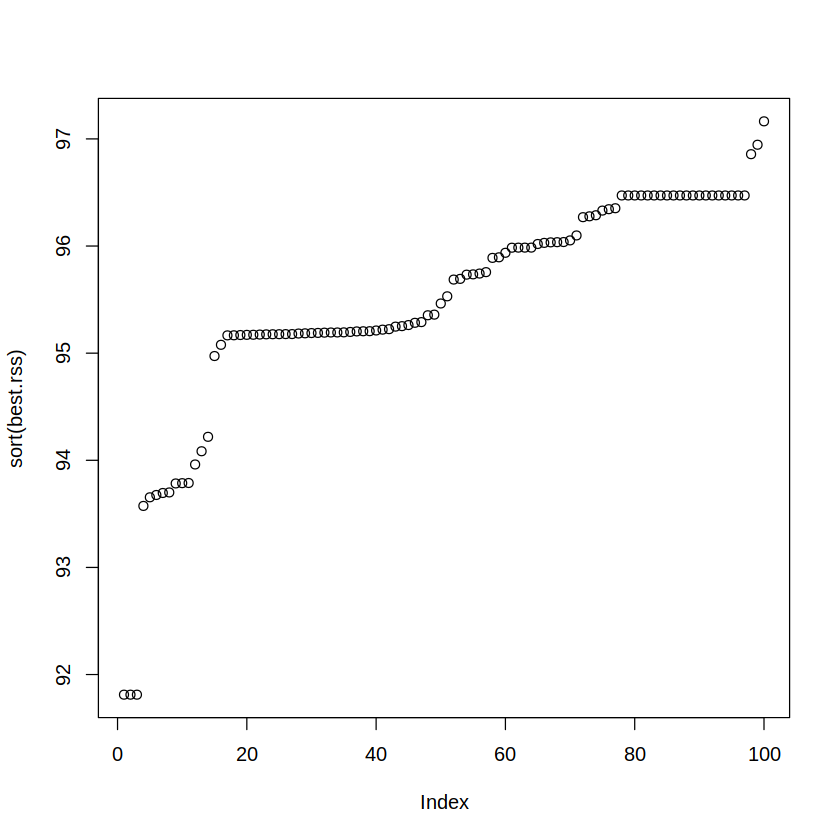

In [14]:
plot(sort(best.rss))


#### Note that another random seed gives a slightly better minimum RSS


In [15]:
set.seed(25374)
best.rss <- NULL
bestrss <- 10000
for (i in 1:100) {
    nnmdl <- nnet(O3 ~ temp + ibh + ibt,
        data = rescaled.ozone, size = 2, linout = T, trace = F
    )
    best.rss[i] <- nnmdl$value
    if (nnmdl$value < bestrss) {
        bestnn <- nnmdl
        bestrss <- nnmdl$value
    }
}

min(best.rss)


[1] 88.14799

#### Now, let’s examine the best model that we found.


In [16]:
summary(bestnn)


a 3-2-1 network with 11 weights
options were - linear output units 
  b->h1  i1->h1  i2->h1  i3->h1 
  -1.11    0.94   -0.84   -0.28 
  b->h2  i1->h2  i2->h2  i3->h2 
 -72.32   35.15 -130.26  -70.70 
   b->o   h1->o   h2->o 
  -1.15    4.47   -0.69 

#### Interpreting nnet output


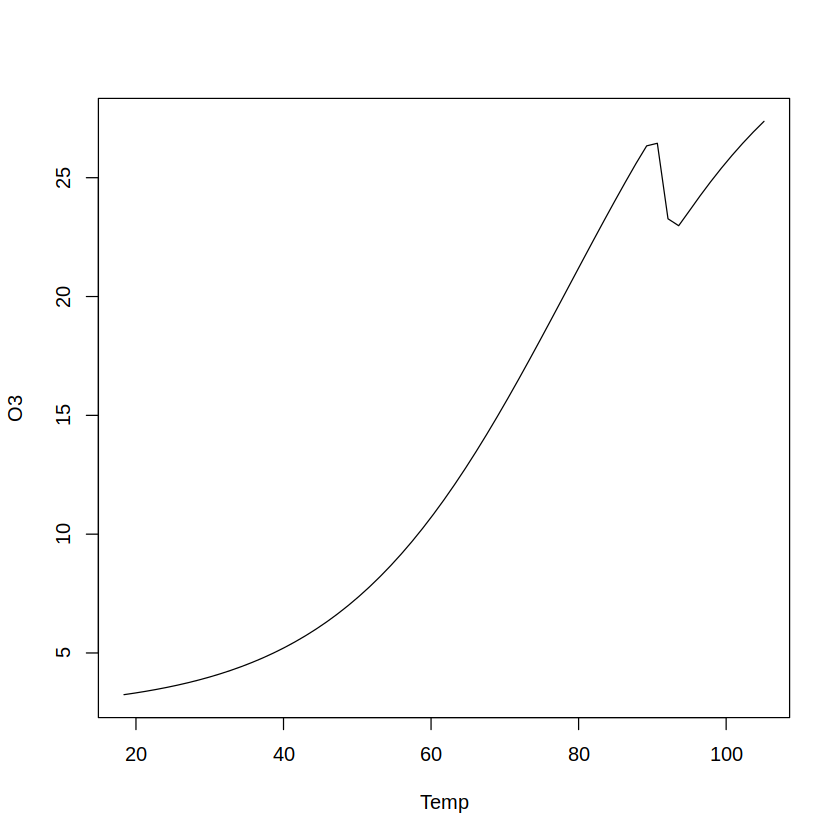

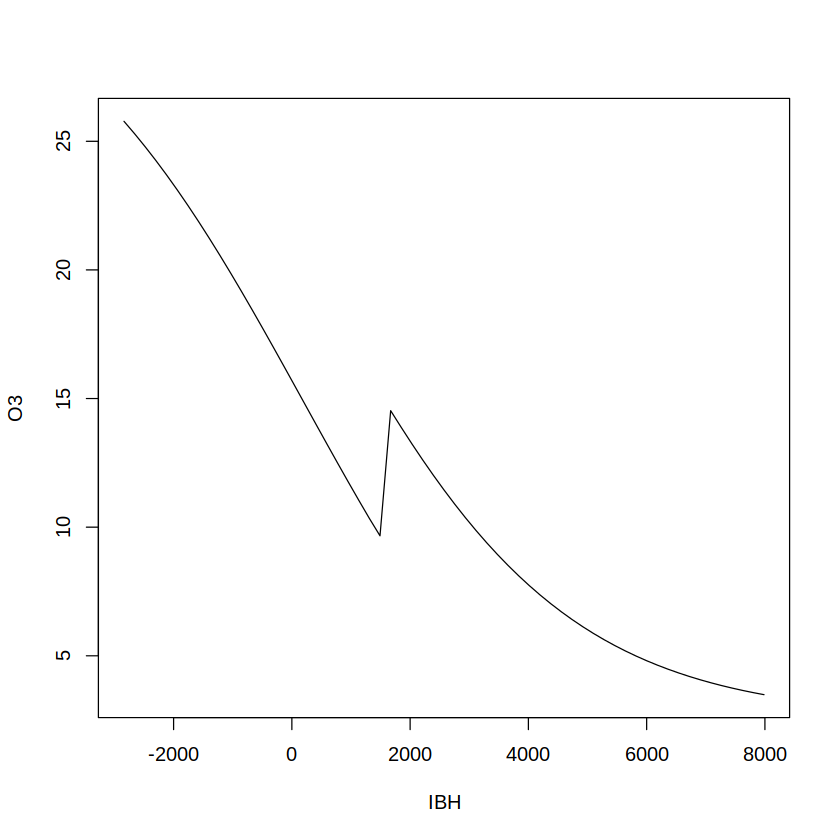

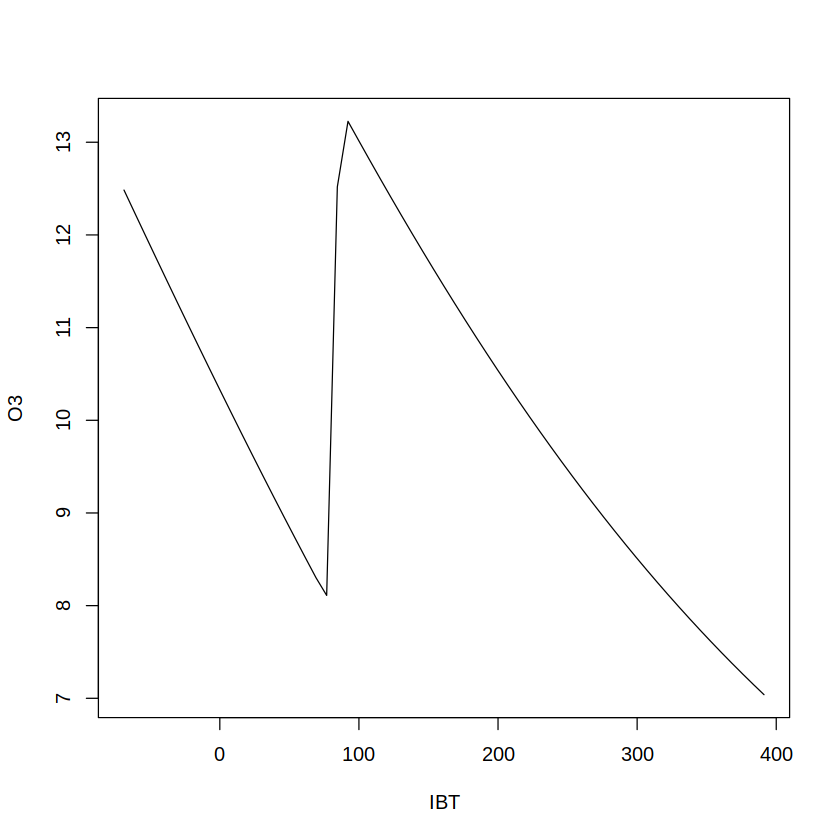

In [17]:
ozmeans <- colMeans(ozone)
ozscales <- apply(ozone, 2, sd)

xx <- expand.grid(temp = seq(-3, 3, 0.1), ibh = 0, ibt = 0)
plot(xx$temp * ozscales["temp"] + ozmeans["temp"],
     predict(bestnn, new = xx) * ozscales["O3"] + ozmeans["O3"],
     xlab = "Temp", ylab = "O3", type = "l"
)


xx <- expand.grid(temp = 0, ibh = seq(-3, 3, 0.1), ibt = 0)
plot(xx$ibh * ozscales["ibh"] + ozmeans["ibh"],
     predict(bestnn, new = xx) * ozscales["O3"] + ozmeans["O3"],
     xlab = "IBH", ylab = "O3", type = "l"
)

xx <- expand.grid(temp = 0, ibh = 0, ibt = seq(-3, 3, 0.1))
plot(xx$ibt * ozscales["ibt"] + ozmeans["ibt"],
     predict(bestnn, new = xx) * ozscales["O3"] + ozmeans["O3"],
     xlab = "IBT", ylab = "O3", type = "l"
)
